# Text Detection & Recognition with Noise
#### **Author:** Zachary Reese <br>
#### **Course:** CPSC548 <br>
#### **Professor:** Dr. Redacted <br>


# Task Definition

**Input:** Natural images <br>
**Output:** (prioritized): <br>
<ol>
    <li>Bounding boxes around text regions</li>
    <li>Characters classified</li>
</ol>

**Motivation:** I aimed to build a CNN pipeline that follows the YOLO architecture of performing both localization and classification within a single pipeline, hence "You Only Look Once." The architecture would perform localization on words within a noisy image (boundary boxes), then classify those words into their computer text equivalent (OCR). Separating real-text data from real-world noise is a common challenge developers attempt to solve, but often don't get reliable/ robust solutions. This is due to the fact that text contains common edge patterns that can be mimiced by real-world noise, such as a flower swaying in the wind. So, most real-world applications stick to well-formatted input images, such as a car's license plate, with a predictable background region. However, an additional challenge is faced when the real-text data is merged ("synthesized") with the background, such as a cheeta's polkadots spelling out the word "Keep!", as found in the SynthText dataset image below. I follow the lessons learned from YOLO versions 1, 2, and 3 on a general Pytorch architecture lay-out provided by Medium that incorporates the main ideas from the YOLO articles.

**Goal:** I aimed to evaluate my model based on Intersection over Union accuracy, its classification accuracy, and how well my model does in comparison to other YOLO models. However, there are no YOLO models readily available specifically tailored to OCR'ing text. Often, YOLO models are used for object classification (like animals or vehicles), but they also specialize in deep feature extraction to detect and classify trained objects, which I can tune towards an OCR task the best I can. So, I aimed to first, reliably locate each word regions. Secondly, if the model localizes text impressively well, say 50%+ IoU accuracy, then I could implement character-level separation and classification on word regions within the same CNN backbone to accomplish a true YOLO architecture for OCR. So, due to the challenges faced by the dataset, the main problem is getting the YOLO architecture to localize text region. My goal is to visually have comparable results to a pre-trained robust boundary box generating model at localizing text. I could compare IoU accuracy, for the pre-trained robust model is likely advanced enough to generate only a few accurate boundary boxes, which would create for an unfair comparison. Regardless, I aimed to produce greater than 20% IoU accuracy, which would prove my model has successfully learned how to detect text via its learned patterns/weights, and isn't overtraining on data or overly spamming guesses. This would prove that my YOLO model has borne fruit on localizing text, on top of visual inspections better showing my model's training results.
<br>

**SynthText Dataset Homepage:** https://www.robots.ox.ac.uk/~vgg/data/scenetext/ <br>
**SynthText Dataset Download:** https://www.kaggle.com/datasets/wassefy/synthtext <br>

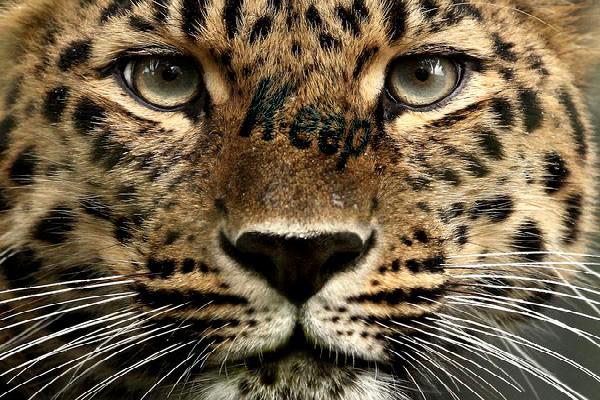

Images within the **SynthText** dataset contains character classification in parallel with word-level boundary boxes, as well as providing character-level boundary boxes. <br>
**Note:** Initially, I worked on character-level boundary boxes, but lowering scope only made sense given that YOLO's task is often to detect entire objects, not necessarily separate them. Though, an update to the CNN backbone could add additional separation and classification heads.

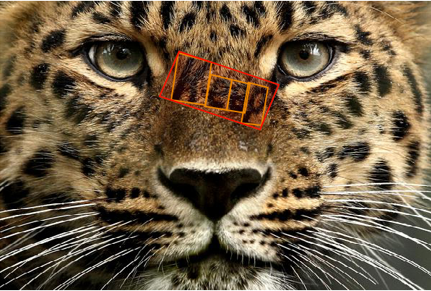

In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pytesseract
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from scipy.io import loadmat
from PIL import Image
from torchvision.transforms import ToPILImage

#pick GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on", device)

Running on cuda


Available fields: dict_keys(['__header__', '__version__', '__globals__', 'imnames', 'charBB', 'wordBB', 'txt'])

Example index: 0
Filename: ballet_106_107.jpg
Number of words: 6
Number of chars: 27
Word texts: ['the' 'was' 'live' 'choose' 'Yet' 'achieved']


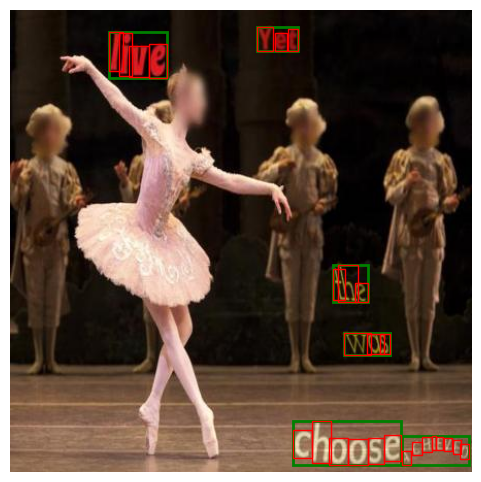

In [2]:
# 1. Load the ground-truth mat
gt = loadmat("datasets/SynthText_sub_resized_4yolo/gt.mat", squeeze_me=True)
print("Available fields:", gt.keys())

imnames  = gt["imnames"]    # list of image filenames
wordBB   = gt["wordBB"]     # word-level boxes
charBB   = gt.get("charBB") # character-level boxes (if present)
txt      = gt["txt"]        # word strings
txtChar  = gt.get("txtChar")# per-character strings (if present)

# 2. Pick one example
idx = 0
print(f"\nExample index: {idx}")
print("Filename:", imnames[idx])
print("Number of words:", wordBB[idx].shape[-1])
if charBB is not None:
    print("Number of chars:", charBB[idx].shape[-1])
print("Word texts:", txt[idx])
if txtChar is not None:
    print("Characters:", txtChar[idx])

# 3. Visualize image + both boxes
img_path = os.path.join("datasets/SynthText_sub_resized_4yolo/images", imnames[idx])
img = Image.open(img_path).convert("RGB")

plt.figure(figsize=(6,6))
plt.imshow(img)
ax = plt.gca()

# draw word-level boxes in green
arr_w = np.array(wordBB[idx], float)
for i in range(arr_w.shape[2]):
    x0, y0 = arr_w[0,:,i].min(), arr_w[1,:,i].min()
    x1, y1 = arr_w[0,:,i].max(), arr_w[1,:,i].max()
    ax.add_patch(plt.Rectangle((x0,y0), x1-x0, y1-y0,
                               edgecolor="g", fill=False, linewidth=2))

# draw char-level boxes in red (if available)
if charBB is not None:
    arr_c = np.array(charBB[idx], float)
    for i in range(arr_c.shape[2]):
        x0, y0 = arr_c[0,:,i].min(), arr_c[1,:,i].min()
        x1, y1 = arr_c[0,:,i].max(), arr_c[1,:,i].max()
        ax.add_patch(plt.Rectangle((x0,y0), x1-x0, y1-y0,
                                   edgecolor="r", fill=False, linewidth=1))

plt.axis("off")
plt.show()

#### The Above Image Visualizes the SynthText Dataset's BB Data (Ground Truth) Set-up:
<font color="green">Green boundary boxes - Words</font> <br>
<font color="red">Red boundary boxes - Characters</font>

## First: Perform Classification on Characters
To skip this section and go back to the YOLO architecture, find section **"Implementing YOLO Architecture."** <br>

First, to determine whether YOLO for OCR was possible on the SynthText dataset, as well as to introduce myself to pytorch CNNs, I decided to first take the original SynthText dataset and crop individual characters from dataset images. The result was a new dataset of cropped characters, giving a reliable baseline as to how doable the classification task itself is. Then, to compare against my trained model, I would use Tesseract by Google to perform character-level OCR on the colorful images of each character. If the resulting classification accuracy from both models are: 
<ol><li>Poor (below 50%): then we know the YOLO tasks are likely impossible due to the data being too noisy. If the resulting classification</li>
    <li>Decent (below 75%): then we know the YOLO task is doable, but likely won't make it to classification.</li>
    <li>Great (above 75%): then we know the YOLO tasks are definitely doable for both localization and classification.</li>
</ol>



## Character OCR CNN Model Definition:
### First, load in data:

In [ ]:
transform = transforms.Compose([
    # ImageFolder loads PIL images by default
    transforms.Resize((32, 32)),                  # if not already 32x32
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],    # normalize RGB image
    #                     std =[0.229, 0.224, 0.225]),
])

full_ds = datasets.ImageFolder(
    root="datasets/step1_chars",
    transform=transform
)
#Pick a random subset of size SUBSET_N
SUBSET_N = 1000
all_idxs = list(range(len(full_ds)))
random.shuffle(all_idxs)
subset_idxs = all_idxs[:SUBSET_N]
subset_ds   = Subset(full_ds, subset_idxs)

#Now split that subset into 80/20
n_train = int(SUBSET_N * 0.8)
n_val   = SUBSET_N - n_train
train_ds, val_ds = random_split(subset_ds, [n_train, n_val])

print(f"Using subset of {SUBSET_N} samples to train={len(train_ds)}, val={len(val_ds)}")

batch_size = 64

train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True,
    num_workers=4, pin_memory=True
)
val_loader = DataLoader(
    val_ds, batch_size=batch_size, shuffle=False,
    num_workers=4, pin_memory=True
)

### Then, define the model:

In [12]:
class OCR_CNN(nn.Module):
    """
    Class name: OCR_CNN
    Description: Convolutional neural network for character classification.
    Parameters:
        n_classes (int): number of character classes (e.g. 62 for A–Z,a–z,0–9)
    """
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)  # 32x32 to 32x32
        self.pool  = nn.MaxPool2d(2, 2)                          # 32x32 to 16x16
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2) # 16x16 to 16x16
        # pool again
        self.flatten = nn.Flatten()
        self.fc1   = nn.Linear(64*8*8, 512)
        self.fc2   = nn.Linear(512, n_classes)

    def forward(self, x): # incoming x is the transformed input image
        """
        Function name: forward
        Description: Define the forward pass for the OCR_CNN.
        Parameters:
            x (torch.Tensor): input batch of shape [B,3,32,32]
        Return Value:
            torch.Tensor: raw logits of shape [B,n_classes]
        """
        x = self.pool(F.relu(self.conv1(x)))  # [B, 32, 16, 16]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 64, 8,  8]
        x = self.flatten(x)                   # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = OCR_CNN(n_classes=len(full_ds.classes)).to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=1e-4,
                              weight_decay=1e-4)

OCR_CNN(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=36, bias=True)
)


### Finally, train the model:

In [ ]:
def train_epoch(loader, print_every=100):
    """
    Function name: train_epoch
    Description: Run one epoch of training for the OCR_CNN on the given DataLoader.
    Parameters:
        loader (DataLoader): batches of (images, labels) for training
        print_every (int): how many batches between printing intermediate loss
    Return Value:
        float: average loss over all samples in the epoch
    """
    model.train()
    running_loss = 0.0
    total_loss = 0.0
    for batch_idx, (imgs, labels) in enumerate(loader, start=1):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss   = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        # accumulate
        running_loss += loss.item()
        total_loss   += loss.item() * imgs.size(0)

        # every "print_every" batches, print the average loss
        if batch_idx % print_every == 0:
            avg = running_loss / print_every
            print(f"  [Batch {batch_idx:4d}/{len(loader):4d}]  "
                  f"avg loss: {avg:.4f}")
            running_loss = 0.0

    epoch_loss = total_loss / len(loader.dataset)
    return epoch_loss

def eval_epoch(loader):
    """
    Function name: eval_epoch
    Description: Evaluate the OCR_CNN on the given DataLoader.
    Parameters:
        loader (DataLoader): batches of (images, labels) for validation
    Return Value:
        tuple(float, float): (average loss, accuracy) over the dataset
    """
    model.eval()
    total_loss = 0.0
    correct = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model(imgs)
            loss   = criterion(logits, labels)
            total_loss += loss.item() * imgs.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

# Run training
n_epochs = 10
for epoch in range(1, n_epochs+1):
    print(f"\n=== Epoch {epoch}/{n_epochs} ===")
    train_loss = train_epoch(train_loader, print_every=200)
    val_loss,  val_acc  = eval_epoch(val_loader)
    print(f" Epoch {epoch} summary:  "
          f"train_loss={train_loss:.4f}  "
          f"val_loss={val_loss:.4f}  "
          f"val_acc={val_acc:.3%}")

## Save the Char Model post-training

In [47]:
filename = "ocr_cnn_step1_testing.pth"
save_dict = {
    "model_state_dict": model.state_dict(),
    "classes":       full_ds.classes,     # list of 36 labels, so you can map preds to char
    "input_channels": 3 if imgs.shape[1]==3 else 1, # Experimenting with grayscale and color, save dynamically.
    "input_size":    imgs.shape[2],       # e.g. 32 (for 32x32)
}
torch.save(save_dict, filename)
print(f"Model and weights saved to `{filename}`")

NameError: name 'full_ds' is not defined

## Load the Char Model

In [49]:
# Pull in the checkpoint I saved after Step 1 character training
ckpt_path = os.path.join("models", "ocr_cnn_step1.pth")
ckpt      = torch.load(ckpt_path, map_location=device)

# Re-instantiate the exact same CNN class
model_cnn = OCR_CNN(n_classes=len(full_ds.classes)).to(device)

# Load its weights & switch to eval mode
model_cnn.load_state_dict(ckpt["model_state_dict"])
model_cnn.eval()

print(f"Loaded character-CNN weights from {ckpt_path}")

NameError: name 'OCR_CNN' is not defined

### Now, we can load in the custom model and compare to Tesseract:

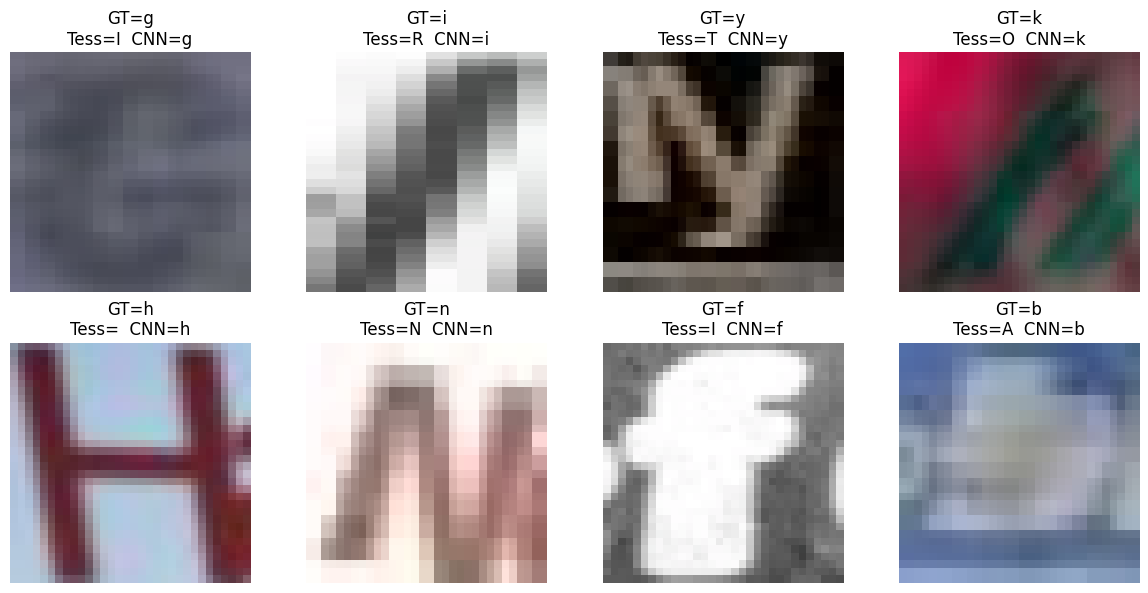

In [21]:
# point pytesseract at the Windows install:
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

def ocr_baseline(pil_img):
    """
    Function name: ocr_baseline
    Description: Run Tesseract OCR on a single PIL image, restricted to ASCII letters and digits.
    Parameters:
        pil_img (PIL.Image): single character image
    Return Value:
        str: the top-confidence character prediction (uppercased) or empty string
    """
    # whitelist A–Z and 0–9
    txt = pytesseract.image_to_string(
        pil_img,
        config='--psm 10 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789'
    )
    return txt.strip().upper()[:1]  # first char or ''

ckpt = torch.load("ocr_cnn_step1.pth", map_location=device)
model_cnn = OCR_CNN(n_classes=len(full_ds.classes)).to(device)
model_cnn.load_state_dict(ckpt["model_state_dict"])
model_cnn.eval()

pilify = ToPILImage()
indices = random.sample(range(len(full_ds)), 8)

fig, axs = plt.subplots(2, 4, figsize=(12, 6))
for ax, idx in zip(axs.flatten(), indices):
    img_tensor, gt = full_ds[idx]
    inv = img_tensor.cpu() * torch.tensor([0.229,0.224,0.225]).view(3,1,1) \
          + torch.tensor([0.485,0.456,0.406]).view(3,1,1)
    pil = pilify(inv.clamp(0,1))

    #Tesseract
    tess_pred = ocr_baseline(pil)

    #Custom CNN
    cnn_logits = model_cnn(img_tensor.unsqueeze(0).to(device))
    cnn_pred = full_ds.classes[cnn_logits.argmax(dim=1).item()]

    ax.imshow(pil)
    ax.set_title(f"GT={full_ds.classes[gt]}\nTess={tess_pred}  CNN={cnn_pred}")
    ax.axis("off")

plt.tight_layout()
plt.show()


# Implementing YOLO Architecture
In this section, I will discuss my final YOLO architecture and how I improved my original design to arrive at my final solution. Throughout, I will discuss which key features had what effect my model and the challenges faced. My unified detection-classification pipline is heavily inspired by the YOLO family of single-stage, efficient object detectors and classifiers. Older architectures took a sliding window across the image and ran confidence checks separate from classification. YOLO builds everything into one architecture by dividing an image into an SxS grid (convolution), then predicts a fixed number of anchor-based boxes along with their objectness scores and class probabilities, all in one single network pass. This allows the model to simutaneously learn patterns between both localization and classification, which should allow for more comprehensive learning patterns. 

## Data/ Model Set-up
The SynthText dataset synthesizes text, or "morphs," text into real-world images, such that the text has minimal separation from the background. Fortunately, YOLO models excel at efficiently learning to localize targets and simutaneously perform classification, which is perfect for an OCR pipline. Though, the original authors of the YOLO models trained on simplier datasets like COCO and PASCAL. So, my model isn't likely to outperform a modern pre-trained BB-OCR pipelined model. However, that doesn't mean I can't implement a starting model and improve it along the way, taking lessons learned from the YOLO articles about what worked and what didn't, and recreating the results myself on the SynthText dataset.

To start, I set up my model to read in from my custom "SynthText_sub_resized_4yolo" dataset. This dataset only contains images from the original SynthText dataset that only contain ascii characters and digits, resulting in a class set of 62. The images are resized to 448x448, converted to RGB, and kept linked to their original gt.mat data file. My model will then take in those 448x448 images and attempt to generate BBs for word regions. The starting point of this project was set-up by a Medium walkthrough ("Implement a YOLO Object Detector from Scratch in PyTorch”). I begin by learning its limitations in anchor design, loss formulation, and training architecture. Then, I systematically extend my architecture with k-means anchor priors, a hybrid multi-term loss function, and refined inference post-prediction. I evaluated my model's success with IpU accuracy on a subset of 5-20k images, which went from the original 4% accuracy up to 28% accuracy by the end.

In [1]:
import os, math, torch, time, cv2, random
import urllib.request
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from scipy.io import loadmat
from PIL import Image
from tqdm import tqdm # progress bar
import torchvision.transforms as T
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import torch.nn.functional as F
from torchvision.ops import generalized_box_iou_loss # giou loss
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision.transforms.functional import to_pil_image
from itertools import islice
from torchvision.ops import box_iou
from torchvision.ops import nms

# Paths
DATA_ROOT    = "datasets/SynthText_sub_resized_4yolo"
IMG_DIR      = os.path.join(DATA_ROOT, "images")
GT_PATH      = os.path.join(DATA_ROOT, "gt.mat")

# Sampling
NUM_SAMPLES  = 20000 #20,000 samples is all that is provided in the SynthText_sub_resized_4yolo dataset. Follow README instructions 
                        #to generate the full dataset, or a subset.

# YOLO config
GRID_SIZE    = 7
NUM_ANCHORS  = 3
NUM_CLASSES  = 1      # single “text” class
INPUT_SIZE   = 448
BATCH_SIZE   = 16
NUM_EPOCHS   = 15
LR           = 1e-5 # was 1e-4 after increasing anchor boxes, and was 1e-3 before that.
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on", DEVICE)

# load full gt.mat
data     = loadmat(GT_PATH, squeeze_me=True, struct_as_record=False)
all_im   = list(data["imnames"].flatten())   # filenames
all_wbb  = list(data["wordBB"].flatten())    # shape (2,4,n_words)
all_txt  = list(data["txt"].flatten())       # list of words

# sample first NUM_SAMPLES
imnames  = all_im[:NUM_SAMPLES]
wordBBs  = all_wbb[:NUM_SAMPLES]
txts     = all_txt[:NUM_SAMPLES]

print(f"Loaded {len(imnames)} samples")

Running on cuda
Loaded 100000 samples


## Anchor Priors via K-Means Clustering
Modern YOLO architectures are able to dynamically generate boundary boxes of various sizes to meet a certain task. However, early iterations of YOLO architectures relied on fixed pre-tailored boundary box sizes to represent potential regions within an image. This isn't very robust, especially during YOLO v1 when these regions were hard-coded. The Medium article also follows YOLO v1 and visually determines which fixed sizes are best. YOLO v2 dynamically calculates a fixed number of average boundary box sizes based on its sampled input, which is what I followed accordingly. Then, we link each ground truth boundary box to its closest fixed-BB size to help tune the model on which box to use when.

In [46]:
dims = []
for bb in wordBBs:
    arr = np.array(bb, dtype=float)
    # if only one word, arr will be shape (2,4) and treated as a single box
    if arr.ndim == 2:
        boxes = [arr]
    else:
        # arr.ndim == 3, shape (2,4,n_words)
        boxes = [arr[:, :, i] for i in range(arr.shape[2])]
    for box in boxes:
        xs = box[0, :]   # the four x-coords
        ys = box[1, :]   # the four y-coords
        w  = xs.max() - xs.min()
        h  = ys.max() - ys.min()
        dims.append([w/448.0, h/448.0])  # normalize by original 512px

dims = np.array(dims)
kmeans = KMeans(n_clusters=5, random_state=42).fit(dims)
ANCHORS = kmeans.cluster_centers_.tolist()
NUM_ANCHORS = len(ANCHORS)

print(f"Learned {NUM_ANCHORS} anchors (w_norm,h_norm):\n{ANCHORS}")


Learned 5 anchors (w_norm,h_norm):
[[0.07028256717983913, 0.0585255474330878], [81.88056252596432, 0.3881431217395863], [0.4652018301348075, 0.2213076873674131], [0.1329705642526875, 0.09522076175513026], [0.24660338484669186, 0.14072523462274733]]


## Data-loading Helper Class and Functions
With anchors pre-calculated, the next crucial step is encoding each ground truth boundary box into the YOLO-style tensor that our model can learn from.

In [3]:
def boxes_to_yolo(bb, target_size=INPUT_SIZE):
    """
    Function name: boxes_to_yolo
    Description: Convert wordBB array into a YOLO-style target tensor.
    Parameters:
        bb (np.ndarray): shape (2,4,n_words) bounding boxes in pixel coords [0,target_size)
        target_size (int): network input resolution (e.g. 448)
    Return Value:
        torch.Tensor: shape [S, S, A*5 + C], encoding tx,ty,tw,th,conf and class
    """
    bb = np.array(bb, dtype=float)
    if bb.ndim == 2: 
        bb = bb[:,:,None]

    S    = GRID_SIZE
    cell = target_size / S
    # target shape: [S, S, A*5 + C]
    target = torch.zeros(S, S, NUM_ANCHORS*5 + NUM_CLASSES)
    
    eps = 1e-6 #epsilon (no divide by zero)
    for i in range(bb.shape[2]):
        xs = bb[0,:,i]; ys = bb[1,:,i]
        x0, x1 = xs.min(), xs.max()
        y0, y1 = ys.min(), ys.max()

        xc, yc = (x0 + x1)/2, (y0 + y1)/2
        w, h  = x1 - x0, y1 - y0

        # normalized box dims
        w_norm, h_norm = w / target_size, h / target_size

        # pick best anchor by IoU of (w_norm,h_norm) vs each ANCHORS[a]
        best_a, best_iou = 0, -1.0
        for a, (aw,ah) in enumerate(ANCHORS):
            inter = min(aw, w_norm)*min(ah, h_norm)
            union = aw*ah + w_norm*h_norm - inter
            iou_a = inter / (union + eps)
            if iou_a > best_iou:
                best_iou, best_a = iou_a, a

        # which grid cell?
        gx = min(int(xc // cell), S-1)
        gy = min(int(yc // cell), S-1)
        
        # skip boxes that fall outside [0, S). Sanity check for larger sample sizes where errors can occur (from SynthText dataset, can't be helped)
        if not (0 <= gx < S and 0 <= gy < S):
            continue
            
        gx = min(max(gx, 0), S-1)
        gy = min(max(gy, 0), S-1)

        # encode tx,ty as before
        tx = (xc - gx*cell) / cell
        ty = (yc - gy*cell) / cell

        # encode tw,th as log‐offset from anchor
        aw, ah = ANCHORS[best_a]
        #tw = np.log(w_norm / (aw + eps) + eps)
        #th = np.log(h_norm / (ah + eps) + eps)
        ratio_w = np.clip(w_norm/aw, 1e-3, 10.0)
        ratio_h = np.clip(h_norm/ah, 1e-3, 10.0)
        # then take the log
        tw = np.log(ratio_w + eps)
        th = np.log(ratio_h + eps)

        base = best_a * 5
        target[gy, gx, base + 0] = tx
        target[gy, gx, base + 1] = ty
        target[gy, gx, base + 2] = tw
        target[gy, gx, base + 3] = th
        target[gy, gx, base + 4] = 1.0           # confidence
        target[gy, gx, NUM_ANCHORS*5:] = 1.0     # “text” class
    return target

class TextYOLODataset(Dataset):
    """
    Class name: TextYOLODataset
    Description: PyTorch Dataset that returns an image tensor and its YOLO target tensor.
    Parameters:
        img_dir (str): directory of images
        imnames (list[str]): filenames of images
        wordBBs (list[np.ndarray]): corresponding word bounding boxes
        transform (callable): torchvision transform to apply to each image
    """
    def __init__(self, img_dir, imnames, wordBBs, transform=None):
        self.img_dir   = img_dir
        self.imnames   = imnames
        self.wordBBs   = wordBBs
        self.transform = transform

    def __len__(self):
        """
        Function name: __len__
        Description: Return the total number of samples in the dataset.
        Parameters: None
        Return Value:
            int: number of images
        """
        return len(self.imnames)

    def __getitem__(self, i):
        """
        Function name: __getitem__
        Description: Load image i, apply transforms, and encode its BBs with boxes_to_yolo.
        Parameters:
            i (int): index into imnames and wordBBs
        Return Value:
            tuple(torch.Tensor, torch.Tensor): (image_tensor, target_tensor)
        """
        name = self.imnames[i]
        img  = Image.open(os.path.join(self.img_dir, name)).convert("RGB")
        if self.transform:
            img = self.transform(img)   # now a tensor 3x448x448
        bb   = self.wordBBs[i]          # np.array (2,4,n_words)
        target = boxes_to_yolo(bb)      
        return img, target

# transforms
transform = T.Compose([
    T.ColorJitter(0.3, 0.3, 0.3, 0.1),         # bright/contrast/sat/hue
    T.ToTensor(),
])

# finally prepare the data for use by the custom YOLO model
dataset = TextYOLODataset(IMG_DIR, imnames, wordBBs, transform)
train_size = int(0.8 * len(dataset))
val_size   = len(dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

## Implementing the YOLO Model
The architecture of this YOLO model is heavily influenced by the YOLO v1 architecture laid out by Medium's article. Noteable improvements made include:
<ol><li>Additional ConvBlock layer for learning more in-depth image features</li>
    <li>LeakyReLU to prevent neurons from dying out and give them a boost.</li></ol>

**ConvBlock:**: Performs 3x3 convolution to mix spacial/feature data from original shape. BatchNorm stabilizes gradients and learning rates. LeakyReLU gives dying neurons a boost. <br>
**YOLOBackbone:** Four stacked ConvBlocks to transform channels from 3 (RGB) to 32, 64, 128, and finally 256. Three 2x2 max-pools transforms the original sized image into its sub-images inbetween each convolutional step, thus how we go from a single 448x448 image to 256 56x56 feature maps. The final ConvBlock keeps the 56x56 resolution, which trades off coarse spatial precision for finer features at the same scale, which is beneficial when working with synthesized data. <br>
**YOLOHead:** After the backbone produces a 256-channel feature map of 56x56 grids, we apply a single 1x1 convolution to collapse the 256 features into a prediction vector. The prediction vector contains five values (x, y, h, w, class) for each anchor. <br>
**YOLO:** Simply packs backbone + head into one nn.Module class inheritance for a neat two-stage forward approach.

In [4]:
class ConvBlock(nn.Module):
    """
    Class name: ConvBlock
    Description: 3x3 Conv -> BatchNorm -> LeakyReLU block for feature extraction.
    Parameters:
        in_c (int): number of input channels
        out_c (int): number of output channels
        k (int): convolution kernel size
        s (int): convolution stride
        p (int): convolution padding
    """
    def __init__(self, in_c, out_c, k, s, p):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_c, out_c, k, s, p),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.1)
        )
    def forward(self, x): 
        """
        Function name: forward
        Description: Apply conv -> batchnorm -> leakyReLU to input tensor.
        Parameters:
            x (torch.Tensor): input feature map
        Return Value:
            torch.Tensor: output feature map
        """
        return self.net(x)

class YOLOBackbone(nn.Module):
    """
    Class name: YOLOBackbone
    Description: Four stacked ConvBlocks (with MaxPool) to produce a 256x56x56 feature map.
    Parameters: None
    """
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            ConvBlock(3,  32, 3, 1, 1), nn.MaxPool2d(2,2),   # 448 to 224
            ConvBlock(32, 64, 3, 1, 1), nn.MaxPool2d(2,2),   # 224 to 112
            ConvBlock(64,128, 3, 1, 1), nn.MaxPool2d(2,2),   # 112 to 56
            ConvBlock(128,256,3, 1, 1),   # 56 to 56 (no pooling); without pooling, the model learns more in-depth features while sticking to a 56x56 feature map.
        )
    def forward(self,x):
        """
        Function name: forward
        Description: Execute the backbone on input images.
        Parameters:
            x (torch.Tensor): input batch [B,3,448,448]
        Return Value:
            torch.Tensor: feature map [B,256,56,56]
        """
        return self.layers(x)

class YOLOHead(nn.Module):
    """
    Class name: YOLOHead
    Description: 1x1 Conv head that maps backbone features to A*5 + C predictions per grid cell.
    Parameters:
        num_anchors (int): number of anchor boxes per cell
        num_classes (int): number of classes (1 for text)
    """
    def __init__(self, num_anchors=NUM_ANCHORS, num_classes=NUM_CLASSES):
        super().__init__()
        # output A*5 + C
        out_ch = num_anchors * 5 + num_classes
        self.det = nn.Conv2d(256, out_ch, kernel_size=1)

    def forward(self, x):
        """
        Function name: forward
        Description: Permute and return raw detection logits [B,S,S,A*5 + C].
        Parameters:
            x (torch.Tensor): backbone features [B,256,S,S]
        Return Value:
            torch.Tensor: detection tensor [B,S,S,A*5 + C]
        """
        # from [B, 128, S, S] -> [B, out_ch, S, S] -> [B, S, S, out_ch]
        return self.det(x).permute(0, 2, 3, 1).contiguous()

class YOLO(nn.Module):
    """
    Class name: YOLO
    Description: Wrapper that combines YOLOBackbone and YOLOHead into a single model.
    Parameters: None
    """
    def __init__(self):
        super().__init__()
        self.backbone = YOLOBackbone()
        self.head     = YOLOHead()

    def forward(self, x):
        """
        Function name: forward
        Description: Forward input through backbone then head to get predictions.
        Parameters:
            x (torch.Tensor): input images [B,3,448,448]
        Return Value:
            torch.Tensor: raw predictions [B,S,S,A*5 + C]
        """
        f = self.backbone(x)
        return self.head(f)

model = YOLO().to(DEVICE)
print(model)

with torch.no_grad():
    dummy = model(torch.zeros(1,3,INPUT_SIZE,INPUT_SIZE).to(DEVICE))

GRID_SIZE = dummy.shape[1]
print("global GRID_SIZE is now", GRID_SIZE)   # should print 56

YOLO(
  (backbone): YOLOBackbone(
    (layers): Sequential(
      (0): ConvBlock(
        (net): Sequential(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.1)
        )
      )
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): ConvBlock(
        (net): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.1)
        )
      )
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): ConvBlock(
        (net): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affin

## Hybrid Multi-term Loss Function
At the heart of any deep detection model lies its loss function- the mathematical objective that guides the network's billions of parameters toward improved prediction results. YOLO's architecture takes into account the accuracy of localizing text, objectness confidence (target vs. background), and classification confidence. The values it calculates with are meaningless by themselves, but the output must be able to tune our model accordingly based on its calculations. It's possible that one value can be calculated to be 100x the size as all others, making all other values meaningless. So, I must carefully tune each parameter after making changes to our model such that one loss value doesn't drown-out all others. This involves arbitrary calculations, such as multiplying a loss by "0.01," such as in the case of classification's weight value. <br>

I also split positive anchors from negative anchors for evaluation as relavent by the individual loss calculations. For example, it doesn't make sense to tune our model's output towards negative predictions. However, we would benefit from learning how the negative predictions vary from the ground truth so that we can tune them better. This is where GIoU loss comes into play. On top of following YOLO's architecture for loss function set-up, towards the end of development, I added a fourth section as an addition to the basic MSE loss calculation on predicted coordinates to calculate GIoU loss. Generalized Intersection over Union loss takes into account both overlaps (like IoU) and relative position (distance from the ground truth box, if not overlapping). This helped my model improve from negative predictions that didn't overlap actual ground truths, to successfully localizing text with a greather than 10% accuracy. <br> 

So, the yolo_loss function sets up the following sub-loss metrics within a single loss function:

**Localization (MSE Loss):** This term measures the mean squared error between the network's predicted box parameters and the corresponding ground truth values. By summing the squared differences and then multiplying by a configurable weight, I ensure that the model receives a strong, continuous gradient signal pushing its predicted box coordinates closer to the ground truth's location. Without this term, the network would have no incentive to refine the precision of its boundary box predictions to be extremely accurate. I.e. GIoU loss only accomplishes generalization, where MSE loss accomplishes exact positioning.  <br>
**Localization (GIoU Loss):** GIoU loss improves basic IoU loss by accounting for both area overlap and the distance between non-overlapping boxes. After converting boundary box data into corner coordinate and normalizing, we compute GIoU for a few negative anchors, for each positive anchor, as well as GIoU loss for positive anchors. This helps tailor predictions to the ground truths even when boxes don't directly overlap, providing non-zero gradients that pull disjoint predictions towards the ground truth. I scale the weight by a small factor to keep the arbitrary value in check with the rest of the weights. <br>
**Objectness (BCE Loss):** For each anchor, the network provides its confidence that each anchor box contains any object of interest. I then compute BCE against a target of 1 for ground truth boxes and 0 for all others. Since background anchors outnumber positives immensely, I randomly sample three times as many negatives as positive in each batch, compute BCE on the subset, then multiply by an arbitrary weight. This drives the model to raise confidence on true text regions while suppressing false boxes, which drives the model to raise confidence on true text proposals while learning to suppress background.    <br>
**Classification (BCE Loss):** In addition to per-anchor objectness, the network predicts one class logit per grid cell to indicate the presence of text. I apply BCE loss only on positive anchors (confident text is within), ensuring to mask out the vast majority of negative anchors. By comparing each cell's predicted class probability against a target of 1 on positive cells, we ensure that classification gradients remain focused on helping the model learn discriminative features for text classification. By applying an arbitrary weight, we can ensure that the classification loss doesn't swamp localization or objectness losses.




In [5]:
def xywh_to_xyxy(boxes):
    """
    Function name: xywh_to_xyxy
    Description: Convert box format (cx,cy,w,h) to (x1,y1,x2,y2) for GIoU.
    Parameters:
        boxes (torch.Tensor): shape [N,4] with center-width-height format
    Return Value:
        torch.Tensor: shape [N,4] with corner coordinates
    """
    cx, cy, w, h = boxes.unbind(-1)
    x1 = cx - w/2
    y1 = cy - h/2
    x2 = cx + w/2
    y2 = cy + h/2
    return torch.stack([x1, y1, x2, y2], dim=-1)

def yolo_loss(pred, target, coord_loss_weight=5, noobj_loss_weight=3, giou_loss_weight=0.05, cls_loss_weight=0.01, debug=False):
    """
    Function name: yolo_loss
    Description: Compute the hybrid YOLO loss (MSE loc, GIoU, objectness BCE, class BCE).
    Parameters:
        pred (torch.Tensor): [B,S,S,A*5+C] raw logits
        target (torch.Tensor): [B,S,S,A*5+C] encoded ground truth
        coord_loss_weight (float): weight for coordinate MSE
        noobj_loss_weight (float): weight for negative-anchor BCE
        giou_loss_weight (float): weight for GIoU loss
        cls_loss_weight (float): weight for classification BCE
        debug (bool): if True, print per-term losses once per batch
    Return Value:
        torch.Tensor: scalar average loss over batch
    """
    B, S, _, _ = pred.shape
    A5, C      = NUM_ANCHORS*5, NUM_CLASSES

    # Split out box+conf vs class
    p_bc  = pred[..., :A5].view(B, S, S, NUM_ANCHORS, 5)
    p_cls = pred[..., A5:]                # [B,S,S,C]
    t_bc  = target[..., :A5].view(B, S, S, NUM_ANCHORS, 5)
    t_cls = target[..., A5:]              # [B,S,S,C]

    obj_mask = (t_bc[...,4] == 1)         # positive anchors
    noobj    = ~obj_mask                  # negative anchors

    # 1. localization (x,y,w,h) only on positives
    coord_loss = coord_loss_weight * F.mse_loss(
        p_bc[..., :4][obj_mask],
        t_bc[..., :4][obj_mask],
        reduction="sum"
    )
    
    # 1b. GIoU loss on the same positives
    if obj_mask.any():
        p_pos = p_bc[..., :4][obj_mask]    # [N_pos,4]
        t_pos = t_bc[..., :4][obj_mask]
        #calculate & normalize
        p_xyxy = xywh_to_xyxy(p_pos).clamp(0, INPUT_SIZE)
        t_xyxy = xywh_to_xyxy(t_pos).clamp(0, INPUT_SIZE)
        p_xyxy /= INPUT_SIZE
        t_xyxy /= INPUT_SIZE
        giou = generalized_box_iou_loss(p_xyxy, t_xyxy, reduction="mean")
    else:
        giou = torch.tensor(0., device=pred.device)

    # 2. Confidence (objectness) with BCE + negative sampling
    # positive anchors
    pos_logits = p_bc[..., 4][obj_mask]
    pos_targets= t_bc[..., 4][obj_mask]
    pos_loss   = F.binary_cross_entropy_with_logits(
        pos_logits, pos_targets, reduction="sum"
    )

    # collect *all* negative logits & targets
    neg_logits_all = p_bc[..., 4][noobj]
    neg_targets_all= t_bc[..., 4][noobj]

    # sample up to 3x negatives per positive
    num_pos = pos_targets.numel() #positive anchor count
    max_neg = min(num_pos * 3, neg_targets_all.numel())
    if max_neg > 0: #if at least one positive anchor
        perm = torch.randperm(neg_targets_all.numel(), device=neg_logits_all.device)[:max_neg] #randomizes and picks first negative anchor
        neg_logits = neg_logits_all[perm] #sampled negative anchor's logits
        neg_targets= neg_targets_all[perm] #which anchor (1 for anchor chosen, 0 for rest)
        neg_loss   = F.binary_cross_entropy_with_logits(
            neg_logits, neg_targets, reduction="sum"
        )
    else: #no positives
        neg_loss = torch.tensor(0.0, device=pred.device)

    conf_loss = pos_loss + noobj_loss_weight * neg_loss

    # 3. Classification loss (per-cell classes) – BCE loss - only compute on cells with any positive anchor
    # p_cls: [B,S,S,C], t_cls: [B,S,S,C], obj_mask: [B,S,S,A]
    cell_obj = obj_mask.any(dim=-1) # [B,S,S] True where text exists
    cls_logits = p_cls[..., 0][cell_obj]
    cls_targets= t_cls[..., 0][cell_obj]
    cls_loss  = F.binary_cross_entropy_with_logits(cls_logits, cls_targets, reduction="sum")
    #cls_loss = F.mse_loss(p_cls, t_cls, reduction="sum")

    total = coord_loss + giou_loss_weight * giou + conf_loss + (cls_loss * cls_loss_weight)
    
    if debug:
        # this will print once per call when debug=True
        print(f"[yolo_loss] coord={coord_loss.item():.1f}, "
              f"giou={giou.item():.1f}, "
              f"pos={pos_loss.item():.1f}, "
              f"neg={neg_loss.item():.1f}, "
              f"cls={cls_loss.item():.1f}, "
              f"conf={conf_loss:.1f}")
    
    return total / B

## Define Optimizer and Scheduler
YOLO v1's architecture uses a scheduler to maintain a constant learning rate over training epochs. However, during my training, simply having a scheduler set to change every certain number of epochs wasn't dynamic enough to how wild my model begins to train. YOLO v1 had the same issue, so during YOLO v2 and v3, I learned that a smoothly decaying learning rate yields more stabale convergence and better final performance. So, I decided to use CosineAnnealing, which gradually cools the learning rate from our initial run down to a 1e-6 minimum. Then, we can supply the number of epochs to ensure that CosineAnnealing doesn't plateu too early. Additionally, YOLO v1 made use of Adam as its basic optimizer function. However, later YOLO v3 proved that AdamW helps achieve better generalization and more stable convergence.

In [6]:
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer,
                              T_max=NUM_EPOCHS,
                              eta_min=1e-6)


## Train the Model
Finally, we can train the network on batches of epochs. On each epoch, I iterate over every batch, compute the hybrid multi-term loss, backpropagate, step the optimizer, accumulate a running loss total, and finally step the scheduler at the end of each epoch. Printing the average training loss allows me to track how the model improves over time, as was made clear in YOLO v3's best practices.

In [7]:
# WARNING: Instead of training the model yourself, you can load in a pre-trained model within the "Load the Model" section.
for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    first_batch = True
    for imgs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        imgs, targets = imgs.to(DEVICE), targets.to(DEVICE)
        preds = model(imgs)
        loss  = yolo_loss(preds, targets, debug=first_batch)
        first_batch = False

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    scheduler.step()
    print(f" Epoch {epoch+1}: train loss = {total_loss/len(train_loader):.4f}")


Epoch 1:   0%|                                                                                | 0/5000 [00:00<?, ?it/s]

[yolo_loss] coord=645.7, giou=-0.8, pos=56.1, neg=148.6, cls=33.0, conf=502.0


Epoch 1:   0%|▏                                                                      | 11/5000 [00:05<44:34,  1.87it/s]


KeyboardInterrupt: 

## Save the Model

In [11]:
os.makedirs("models", exist_ok=True)
filename = "saving_yolo_model_to_this_file.pth"
save_path = os.path.join("models", filename)
torch.save(model.state_dict(), save_path)
print(f"Saved model weights to {save_path}")

Saved model weights to models\saving_model_to_this_file.pth


## Load the Model

In [7]:
model = YOLO().to(DEVICE)

# Load the saved weights
checkpoint_path = "models/biggest_overnight_run_100k.pth"
state_dict = torch.load(checkpoint_path, map_location=DEVICE)
model.load_state_dict(state_dict)

# Switch to eval mode
model.eval()
print(f"Loaded pretrained weights from {checkpoint_path}")

Loaded pretrained weights from models/biggest_overnight_run_100k.pth


## Compare Against Well-Tuned BB Generating Model
The best, readily available model I could find after extensive research was EAST

In [8]:
# Download & load EAST
url = "https://raw.githubusercontent.com/oyyd/frozen_east_text_detection.pb/master/frozen_east_text_detection.pb"
urllib.request.urlretrieve(url, "frozen_east_text_detection.pb")
east_net = cv2.dnn.readNet("frozen_east_text_detection.pb")


## Define Necessary Helper Functions

In [19]:
#Helpers for EAST:
def decode_east(scores, geometry, score_thresh=0.5):
    """
    Function name: decode_east
    Description: Convert EAST network outputs into raw bounding-box rectangles and confidences.
    Parameters:
        scores (np.ndarray): text-confidence map [1,1,H,W]
        geometry (np.ndarray): box geometry maps [1,5,H,W]
        score_thresh (float): minimum score to consider a detection
    Return Value:
        tuple(list[tuple], list[float]): (rects, confs)
    """
    H, W = scores.shape[2:]
    rects, confs = [], []
    for y in range(H):
        sc = scores[0,0,y]
        x0,x1,x2,x3 = [geometry[0,i,y] for i in range(4)]
        ang = geometry[0,4,y]
        for x in range(W):
            if sc[x] < score_thresh: 
                continue
            offX, offY = x*4.0, y*4.0
            cosA, sinA = np.cos(ang[x]), np.sin(ang[x])
            h = x0[x]+x2[x]; w = x1[x]+x3[x]
            ex = offX + cosA*x1[x] + sinA*x2[x]
            ey = offY - sinA*x1[x] + cosA*x2[x]
            sx,sy = ex - w, ey - h
            rects.append((int(sx),int(sy),int(ex),int(ey)))
            confs.append(float(sc[x]))
    return rects, confs

def detect_text_east(img, net, conf_thresh=0.5, nms_thresh=0.4, input_size=320):
    """
    Function name: detect_text_east
    Description: Run the EAST detector on an image and apply NMS.
    Parameters:
        img (np.ndarray): BGR image array
        net (cv2.dnn_Net): pre-loaded EAST network
        conf_thresh (float): minimum confidence threshold
        nms_thresh (float): IoU threshold for non-max suppression
        input_size (int): size to which image is resized
    Return Value:
        list[tuple]: list of (x1,y1,x2,y2) detections in original image coords
    """
    H,W = img.shape[:2]
    newW=newH=input_size
    rW, rH = W/float(newW), H/float(newH)
    blob = cv2.dnn.blobFromImage( # parameters according to EAST model's set-up
        img, 1.0, (newW,newH), (123.68,116.78,103.94),
        swapRB=True, crop=False
    )
    net.setInput(blob)
    scores, geometry = net.forward([ # more parameters according to EAST model's set-up
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"
    ])
    rects, confs = decode_east(scores, geometry, score_thresh=conf_thresh)
    # apply NMS
    idxs = cv2.dnn.NMSBoxes(rects, confs, conf_thresh, nms_thresh)
    # if no boxes remain, NMSBoxes can return [] or () or None
    if idxs is None or len(idxs) == 0:
        return []
    # normalize to flat list of ints
    idxs = np.array(idxs).flatten()
    boxes = []
    for i in idxs:
        sx,sy,ex,ey = rects[int(i)]
        boxes.append((
            int(sx * rW), int(sy * rH),
            int(ex * rW), int(ey * rH)
        ))
    return boxes

#Helpers for custom CNN:
#conf: high- confident. low- non-confident
#iou: high- only merge identical boxes. low- any similar boxes will be merge, but still different sizes are let thru.
def postprocess(pred, conf_thresh=0.9, iou_thresh=0.01, topk=100):
    """
    Function name: postprocess
    Description: Convert raw YOLO logits into final boxes after sigmoid, scaling, and NMS.
    Parameters:
        pred (torch.Tensor): [S,S,A*5+C] raw detection logits
        conf_thresh (float): minimum objectness to keep
        iou_thresh (float): NMS IoU threshold
        topk (int): keep only top-k before applying NMS
    Return Value:
        list[list]: [[x1,y1,x2,y2,conf],...] final detections
    """
    S = GRID_SIZE
    cell_size = INPUT_SIZE / S

    # first, convert the box+conf logits to “probabilities” via sigmoid
    p = pred.clone()
    # sigmoid on x,y,conf (first 3*5 dims) — will apply only to every 5th for conf  
    # but simplest is to sigmoid the entire slice [0:A5]:
    A5 = NUM_ANCHORS*5
    p[..., :A5] = torch.sigmoid(p[..., :A5])  
    # class‐probs
    p[..., A5:] = torch.sigmoid(p[..., A5:])

    boxes, scores = [], []
    arr_scores = p.cpu().numpy()  # now in [0,1]
    #for every grid cell (i,j) and every anchor a:
    for i in range(S):
        for j in range(S):
            for a in range(NUM_ANCHORS):
                base = a*5
                conf = arr_scores[i, j, base+4]
                if conf < conf_thresh:
                    continue

                tx = arr_scores[i, j, base+0]
                ty = arr_scores[i, j, base+1]
                tw = arr_scores[i, j, base+2]
                th = arr_scores[i, j, base+3]

                # map back to full-image coords
                cx = (j + tx) * cell_size
                cy = (i + ty) * cell_size
                
                aw, ah = ANCHORS[a]
                w  = np.exp(tw) * aw * INPUT_SIZE
                h  = np.exp(th) * ah * INPUT_SIZE

                x1, y1 = cx - w/2, cy - h/2
                x2, y2 = cx + w/2, cy + h/2
                boxes.append([x1, y1, x2, y2])
                scores.append(conf)

    if not boxes:
        return []
    #to speed up NMS, keep only the top-k highest confidence BBs
    boxes_t  = torch.tensor(boxes)
    scores_t = torch.tensor(scores)
    if len(scores_t) > topk:
        idxs = scores_t.topk(topk).indices
        boxes_t  = boxes_t[idxs]
        scores_t = scores_t[idxs]
        
    keep = nms(boxes_t, scores_t, iou_thresh) #removes overlapping boxes
    return [[*boxes_t[k].tolist(), float(scores_t[k])] for k in keep]

def iou(boxA, boxB):
    """
    Function name: iou
    Description: Compute Intersection-over-Union of two axis-aligned boxes.
    Parameters:
        boxA (tuple[float]): (x1,y1,x2,y2)
        boxB (tuple[float]): (x1,y1,x2,y2)
    Return Value:
        float: IoU score in [0,1]
    """
    xA,yA,xB,yB = max(boxA[0],boxB[0]), max(boxA[1],boxB[1]), min(boxA[2],boxB[2]), min(boxA[3],boxB[3])
    inter = max(0,xB-xA)*max(0,yB-yA)
    aA, aB = (boxA[2]-boxA[0])*(boxA[3]-boxA[1]), (boxB[2]-boxB[0])*(boxB[3]-boxB[1])
    return inter / (aA + aB - inter + 1e-6)

## IoU Accuracy Comparison
Intersection over Union takes into account how much two boundary boxes overlap. For my case, I check the best prediction from my model for each ground truth boundary box. This means that for six ground truths words for example, there will only <=6 boundary box predictions chosen to calculate IoU with. Thus, cluttered boundary boxes aren't accounted into the accuracy calculation.

In [31]:
N = 100
indices = val_ds.indices[:N]

yolo_ious = []
east_ious = []

for orig_idx in indices:
    # Build ground-truth boxes
    bb = wordBBs[orig_idx]
    arr = np.array(bb, dtype=float)
    if arr.ndim == 2:
        arr = arr[:, :, None]
    gt_boxes = []
    for i in range(arr.shape[2]):
        xs, ys = arr[0,:,i], arr[1,:,i]
        x0, x1 = xs.min(), xs.max()
        y0, y1 = ys.min(), ys.max()
        gt_boxes.append([x0, y0, x1, y1])

    # EAST detections
    img_path = os.path.join(IMG_DIR, imnames[orig_idx])
    img_bgr  = cv2.imread(img_path)
    boxes_east = detect_text_east(img_bgr, east_net,
                                  conf_thresh=0.5, nms_thresh=0.4)

    # Custom YOLO detections
    img_t, _ = dataset[orig_idx]
    with torch.no_grad():
        p = model(img_t.unsqueeze(0).to(DEVICE))[0]
    pred_boxes = postprocess(p, conf_thresh=0.3, iou_thresh=0.4)
    yolo_coords = [b[:4] for b in pred_boxes]

    # Compute best‐IoU per GT box
    for g in gt_boxes:
        best_e, best_y = 0, 0
        for e in boxes_east:
            best_e = max(best_e, iou(g, e))
        for yb in yolo_coords:
            best_y = max(best_y, iou(g, yb))
        east_ious.append(best_e)
        yolo_ious.append(best_y)

print(f"EAST  avg IoU over {N} images: {np.mean(east_ious):.3f}")
print(f"YOLO  avg IoU over {N} images: {np.mean(yolo_ious):.3f}")

#Note: IoU doesn't reflect negatives, only positives. It picks the best overlap for each ground truth box.

EAST  avg IoU over 100 images: 0.193
YOLO  avg IoU over 100 images: 0.262


## Visualization of Boundary Box Predictions and Ground Truth

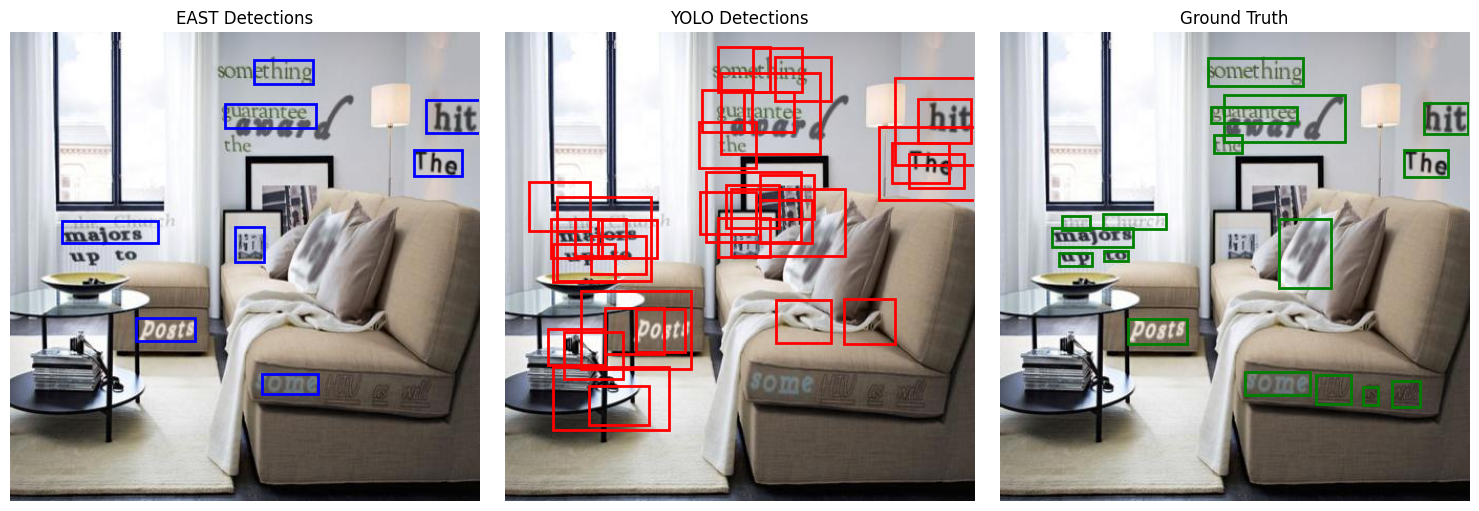

In [45]:
# Pick a random image from validation
idx = random.choice(val_ds.indices)

# Load raw image and ground‐truth boxes
img_path = os.path.join(IMG_DIR, imnames[idx])
pil_img  = Image.open(img_path).convert("RGB")
bb       = wordBBs[idx]
arr      = np.array(bb, dtype=float)
if arr.ndim == 2:
    arr = arr[:, :, None]
gt_boxes = []
for i in range(arr.shape[2]):
    xs, ys = arr[0,:,i], arr[1,:,i]
    x0, x1 = xs.min(), xs.max()
    y0, y1 = ys.min(), ys.max()
    gt_boxes.append((x0, y0, x1, y1))

# EAST predictions
bgr = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)
east_boxes = detect_text_east(
    bgr, east_net,
    conf_thresh=0.5,
    nms_thresh=0.4,
    input_size=320
)

# YOLO predictions
img_t, _ = dataset[idx]
with torch.no_grad():
    p = model(img_t.unsqueeze(0).to(DEVICE))[0]
yolo_boxes = postprocess(p, conf_thresh=0.3, iou_thresh=0.4)

# Plot side by side: EAST, YOLO, Ground‐Truth
fig, axes = plt.subplots(1, 3, figsize=(15,5), dpi=100)
titles = ["EAST Detections", "YOLO Detections", "Ground Truth"]
for ax, title in zip(axes, titles):
    ax.imshow(pil_img)
    ax.set_title(title)
    ax.axis("off")

# Draw EAST boxes in blue
for (x0,y0,x1,y1) in east_boxes:
    axes[0].add_patch(plt.Rectangle(
        (x0,y0), x1-x0, y1-y0,
        edgecolor='b', fill=False, linewidth=2
    ))

# Draw YOLO boxes in red
for (x0,y0,x1,y1,_) in yolo_boxes:
    axes[1].add_patch(plt.Rectangle(
        (x0,y0), x1-x0, y1-y0,
        edgecolor='r', fill=False, linewidth=2
    ))

# Draw GT boxes in green
for (x0,y0,x1,y1) in gt_boxes:
    axes[2].add_patch(plt.Rectangle(
        (x0,y0), x1-x0, y1-y0,
        edgecolor='g', fill=False, linewidth=2
    ))

plt.tight_layout()
plt.show()

## Conclusion
In this project, I built a unified YOLO-style detector for text localization and classification from scratch in Pytorch. By tracking baselines and implementing oracles, I gained a clear lower and upper bound on performance. If I could go back and change my project's goal, I'd actually increase the IoU threshold for project success. Originally, I set out to accomplish a 20% IoU accuracy with my YOLO model. However, this isn't realistic to generating BB data useful for classification. So, I would have set out to accomplish at least 50% accuracy. Meanwhile, my current model only reached ~27% accuracy. Which still out-classed the EAST baseline under the same IoU metric, even though EAST visually appears "cleaner" by throwing away all but the most confident BB proposals. My model lacks the same confidence EAST does, but this is likely due to being trained on 15 epochs for 100k samples, whereas traditional YOLO models train for at least 50 epochs. Had my model been backed by more powerful hardware, my model could have more brute forced the BB generation task rather than surgically solve it. Though, my model seems to be very close to convergence, it's still missing key improvements made on the backbone CNN architecture in later iterations of the YOLO architecture, especially to accomplish convergence on the SynthText dataset. 

Regardless, I will be further working on this model's architecture to see how far it can go, such as training on all ~200k images in the SynthText_sub_resized_4yolo dataset for 50 epochs. If my model achieves impressive results, I will post updates and further studies on implementing more advanced machine learning models for real-world applications on my GitHub profile: https://github.com/Zach879. Noteably my GitHub contains my KU Capstone Project (Shopping Aggregator), as well as my BCTC Final Project from four years ago, which performs a similar function to the aforementioned YOLO model on a much simplier custom dataset. I plan to post more research updates once I get situated post-graduation, such that I can quickly catch up to modern architectures with a mix of building models from scratch, as well as utilizing pre-trained models. My end goal is to create a dynamic, efficient, live-processing model to track moving and still objects on a moving agent, such that it can inference which actions and moves changes said environment in a way to meet pre-programmed tasks without human interference, while being able to detect when it fails and adapt accordingly.

# References (IEEE Citations)
<ol>  
     <li>"Main" "Medium Article": whyamit, “How to Implement a YOLO Object Detector from Scratch in PyTorch,” Medium. Feb. 08, 2025. Available: https://medium.com/@whyamit404/how-to-implement-a-yolo-object-detector-from-scratch-in-pytorch-e310829d92e6  </li>
    <li>YOLO v1: J. Redmon, S. Divvala, R. Girshick, and A. Farhadi, “You Only Look Once: Unified, Real-Time Object Detection.” arXiv, 2015. doi: 10.48550/ARXIV.1506.02640. Available: https://arxiv.org/abs/1506.02640</li>
    <li>YOLO v2: J. Redmon and A. Farhadi, “YOLO9000: Better, Faster, Stronger.” arXiv, 2016. doi: 10.48550/ARXIV.1612.08242. Available: https://arxiv.org/abs/1612.08242</li>
    <li>YOLO v3: J. Redmon and A. Farhadi, “YOLOv3: An Incremental Improvement.” arXiv, 2018. doi: 10.48550/ARXIV.1804.02767. Available: http://arxiv.org/abs/1804.02767</li>
    <li> 	
“Intersection over Union (IoU): Definition, Calculation, Code,” www.v7labs.com. Available: https://www.v7labs.com/blog/intersection-over-union-guide</li>
    <li> H. Rezatofighi, N. Tsoi, J. Gwak, A. Sadeghian, I. Reid, and S. Savarese, “Generalized Intersection over Union,” giou.stanford.edu. 2018. Available: https://giou.stanford.edu/</li>
    <li>S. T. PhD, “YOLO v1 implementation: dataset class creation,” Medium. Apr. 29, 2025. Available: https://medium.com/@telega.slawomir.ai/yolo-v1-implementation-dataset-class-creation-0822eea4b7fa</li>
    <li> Y. Zhang, “How is Pytorch’s binary_cross_entropy_with_logits function related to sigmoid and…,” Medium. Aug. 25, 2019.  Available: https://zhang-yang.medium.com/how-is-pytorchs-binary-cross-entropy-with-logits-function-related-to-sigmoid-and-d3bd8fb080e7</li>
    <li> U. Mallick, “Cosine Learning Rate Schedulers in PyTorch,” Medium. Medium, Nov. 20, 2024. Available: https://medium.com/@utkrisht14/cosine-learning-rate-schedulers-in-pytorch-486d8717d541</li>
    <li> “Datasets & DataLoaders — PyTorch Tutorials 2.7.0+cu126 documentation,” docs.pytorch.org. Available: https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html</li>
    <li>KMeans,” scikit-learn. Available: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html</li>
    <li> N. Phongchit, “How to Fix Imbalanced Classes with Focal Loss,” Medium. Oct. 03, 2024. Available: https://medium.com/@natthawatphongchit/how-to-fix-imbalanced-classes-with-focal-loss-559de3ef94a3</li>
    <li>M. R, “Scene Text Detection In Python With EAST and CRAFT,” Medium. Jul. 11, 2021. Available: https://medium.com/technovators/scene-text-detection-in-python-with-east-and-craft-cbe03dda35d5</li>
    <li> “frozen_east_text_detection.” Apr. 02, 2019. Available: https://www.kaggle.com/datasets/yelmurat/frozen-east-text-detection/data</li>
    <li> V. Shrimali, “Deep Learning Based Text Detection Using OpenCV (C++/Python),” learnopencv.com. Jan. 28, 2019.  Available: https://learnopencv.com/deep-learning-based-text-detection-using-opencv-c-python/</li>
    <li> “Visual Geometry Group - University of Oxford,” www.robots.ox.ac.uk. Available: https://www.robots.ox.ac.uk/~vgg/data/scenetext/</li>
    <li> “SynthText.” Dec. 29, 2022. Available: https://www.kaggle.com/datasets/wassefy/synthtext</li>
    <li>J. Prakash, “Non Maximum Suppression: Theory and Implementation in PyTorch,” learnopencv.com. Jun. 02, 2021. Available: https://learnopencv.com/non-maximum-suppression-theory-and-implementation-in-pytorch/</li>
</ol>